# <span style="color:purple">Week 3 -- Clustering & Topic Modeling</span> 
### <span style="color:purple">SunnyJy's Movie Kingdom</span>  
<span style="color:purple">-- File: Jingying (Jane) Bi Homework <br>
-- Name: Jingying Bi <br>
-- UCID: 12174556 <br>
<br>

![title](M.jpg)

<span style="color:purple"> **Brief description of my work:** <br>
In this project, I will study the clustering and topic modeling through movie reviews. I collect movies whoes main genre belongs to comedy, animation, action, and crime. I sellect these four genres purposefully because IMBD has a list of genres which are quite close to each other. I try to find four more distinct genres so that the movies and critics I scrape will have sufficient large differences for clustering. Meanwhile, comedy and animation are closer to each other and crime and action are closer to each other. I would like to see how the clusterings look like and whether it will capture this. <br>
I will do the following things. <br>
**(1)** Use web scraping to scrape Movies on [IMDB](http://www.imdb.com/) to collect information including Movie's title, genre, and 1 movie critics. The information will be recorded in a DataFrame. In total, there are 4 categories of genres, and each genre has 50 movie critics.<br>
**(2)** Flat Clustering Analysis <br>
**(3)** Hierarchical Clustering Analysis <br>
**(4)** Topic Modeling <br>
</span>


# Web Scraping Movie Critics 

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# For web scraping
from bs4 import BeautifulSoup
import requests #for http requests
from requests import get
import pandas #gives us DataFrames
import re #for regexs
import numpy as np #math calculation
import urllib

import matplotlib.pyplot as plt

In [3]:
category = ['comedy','crime','action','animation']
# tail[1]: comedy; tail[2]: crime; tail[3]: action; tail[4]:animation

Movie_Title = []
Movie_Genre = []
Movie_Critic = []
Movie_Category = []

num_page = 1

In [43]:
for i in range(0,4):  # for loop for the 4 categories -- i category    
    for j in range(1,num_page+1):  # for loop for the pages of category i (each page contains 50 movies) -- j num_page
        print('enter a page', j, 'in category', category[i])
        heading = 'http://www.imdb.com/search/title?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=2251824562&pf_rd_r=0DP960VPZ9A5CFX59VGA&pf_rd_s=right-6&pf_rd_t=15506&pf_rd_i=moviemeter&genres='
        url = heading + category[i] + '&explore=title_type,genres&page=' + str(j) + '&ref_=adv_nxt'
        response = get(url)
        beautiSoup = BeautifulSoup(response.text, 'html.parser')
        movie_tank = beautiSoup.find_all('div', class_ = 'lister-item mode-advanced')
        for k in range(0,50):  # for loop for the 50 movies on page j -- k movie
            print('enter a movie', k)
            
            # movie_id
            movie_link = 'http://www.imdb.com/' + movie_tank[k].h3.a.get('href')      # <<--- change 0 to k
            movie_id = re.search(r'tt\d+', movie_link).group(0)

            # movie critic
            critic_page_link = 'http://www.imdb.com/title/' + movie_id + '/externalreviews?ref_=tt_ov_rt'
            response_2 = get(critic_page_link)
            beautiSoup_2 = BeautifulSoup(response_2.text, 'html.parser')
            critic_list = beautiSoup_2.find_all('a', attrs = {'href': re.compile('^\/offsite\/\?page\-action\=offsite\-')})
            # need to check the URLErro
            def CheckError(url):
                try: 
                    urllib.request.urlopen(url)
                    #response = get(url) 
                    #html=urlopen(url)
                except urllib.error.HTTPError as e:
                    return -1
                except urllib.error.URLError as e:
                    print('url error')
                    return -2
                return 1
            if CheckError(critic_page_link) < 0:
                print('critic page cannot be opened')
            else: 

                if critic_list == []:
                    print('no critic for category', category[i], 'for movie', k, 'on page', j)
                else:
                    # Find one critic will be good.
                    # However, I have to find a critic in English.
                    # Therefore, I will build a loop until the first English page critic is obtained.
                    gotIt = 0
                    n = 0
                    max_n = len(critic_list)
                    critic = []
                    while gotIt == 0 and n < max_n:
                        critic_name = critic_list[n].text
                        a = re.search(r'\(', critic_name) 
                        if a is None: 
                            #print('english!')
                            #gotIt = 1
                            critic_link = 'http://www.imdb.com' + critic_list[n].get('href')
                            response_3 = get(critic_link)
                            beautiSoup_3 = BeautifulSoup(response_3.text, 'html.parser')
                            paragraph = beautiSoup_3.find_all('p')
                            if len(paragraph) > 15: # have enough paragraphs
                                for p in paragraph:
                                    if len(p.text) >100: # eliminate noises
                                        critic.append(p.text)
                                gotIt = 1
                            else:
                                n += 1
                                print('too short')      
                        else:
                            print('nonEnglish!')
                            n += 1
                    Movie_Critic.append(critic)   #**

                    # movie title
                    title = movie_tank[k].h3.a.text   # <<--- change 0 to k
                    Movie_Title.append(title) #**

                    # movie genres
                    genre = []
                    response_1 = get(movie_link)
                    beautiSoup_1 = BeautifulSoup(response_1.text, 'html.parser')
                    genre_list = beautiSoup_1.find('div', class_="see-more inline canwrap", attrs = {'itemprop':"genre"})
                    genre_item = genre_list.find_all('a')
                    for item in genre_item:
                        genre.append(item.text)
                    Movie_Genre.append(genre) #**

                    # Movie Category
                    Movie_Category.append(category[i])
                    #print('OKOKOKOKOKO')


enter a page 1 in category comedy
enter a movie 0
enter a movie 1
enter a movie 2
nonEnglish!
too short
enter a movie 3
too short
nonEnglish!
too short
nonEnglish!
enter a movie 4
enter a movie 5
enter a movie 6
too short
too short
enter a movie 7
enter a movie 8
too short
too short
too short
too short
too short
too short
too short
too short
too short
too short
too short
nonEnglish!
enter a movie 9
enter a movie 10
too short
enter a movie 11
enter a movie 12
enter a movie 13
enter a movie 14
enter a movie 15
enter a movie 16
enter a movie 17
enter a movie 18
enter a movie 19
too short
too short
too short
too short
too short
too short
too short
too short
too short
nonEnglish!
enter a movie 20
enter a movie 21
enter a movie 22
nonEnglish!
nonEnglish!
enter a movie 23
enter a movie 24
enter a movie 25
enter a movie 26
enter a movie 27
enter a movie 28
enter a movie 29
no critic for category comedy for movie 29 on page 1
enter a movie 30
nonEnglish!
enter a movie 31
enter a movie 32
enter 

In [58]:
Movie_Kingdom = pandas.DataFrame({'Movie Title': Movie_Title,
                                  'Movie Category': Movie_Category,
                                  'Movie Genre': Movie_Genre,
                                  'Movie Critic': Movie_Critic})
Movie_Kingdom.to_csv('MovieKingdom.csv', sep=',')
Movie_Kingdom.to_excel('MovieKingdom.xlsx','Sheet1')

In [59]:
Movie_Kingdom.to_csv(r'MovieKingdom.txt', header=None, index=None, sep=' ', mode='a')

# Flat Clustering Analysis
## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? a

In [138]:
# load DataFrame Movie_Kingdom
Movie_Kingdom = pandas.read_csv('MovieKingdom.csv')
del Movie_Kingdom['Unnamed: 0']
#Movie_Kingdom[:5]

<span style="color:purple"> I have set the parameters of *sklearn.feature_extraction.text.TfidfVectorizer* as below:<br>
 * <span style="color:purple">max_df=0.5 -- ignore terms whose proportions are strictly higher 0.5. <br>
 * <span style="color:purple">min_df=3 -- ignore terms whose frequencies are strictly lower 3 times. <br>
 * <span style="color:purple">max_features=1000 -- only consider the top 1000 ordered by term frequency across the corpus.<br>

In [139]:
# Count Vectorizer
MovieCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
MovieVects = MovieCountVectorizer.fit_transform(Movie_Kingdom['Movie Critic'])

# Tf-idf Transformer
MovieTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(MovieVects)
MovieTF = MovieTFTransformer.transform(MovieVects)

# Tf-idf Vectorizer
MovieTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
MovieTFVects = MovieTFVectorizer.fit_transform(Movie_Kingdom['Movie Critic'])

In [140]:
# number of clusters
num_Clusters = len(set(Movie_Kingdom['Movie Category']))

# initialize K-means
km = sklearn.cluster.KMeans(n_clusters=num_Clusters, init='k-means++')
km.fit(MovieTFVects)

# Metrics to evaluate the clusters
#print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(Movie_Kingdom['Movie Category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(Movie_Kingdom['Movie Category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(Movie_Kingdom['Movie Category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(Movie_Kingdom['Movie Category'], km.labels_)))


Homogeneity: 0.021
Completeness: 0.027
V-measure: 0.024
Adjusted Rand Score: 0.000


### <span style="color:purple"> Add analysis of the metrics results!!!! </span>

In [141]:
# predict the k-means
Movie_Kingdom['Kmeans Prediction'] = km.labels_

# Top terms in each cluster
terms = MovieTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_Clusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 uses
 number
 media
 original
 com
 james
 day
 father
 american
 said


Cluster 1:
 ebert
 test
 club
 members
 xa0
 films
 named
 action
 movies
 space


Cluster 2:
 season
 episodes
 episode
 family
 shows
 netflix
 comedy
 things
 tv
 mr


Cluster 3:
 common
 ratings
 crime
 media
 military
 sense
 development
 practices
 expert
 sex




<span style="color:purple"> The *Top terms list* per cluster matches the categories. I have 4 categories: comedy, crime, action and animation. The *Top term list* of Cluster 1 has "crime", Cluster 2 has "action", Cluster 3 has "comedy". They tend to match 3 out od 4 categories, though the *Top term list* of Cluster 0 does not contain word "animation", other words such as "game", "happy", "fantasy" reflect the category "animation".

In [161]:
# PCA to reduce the dimensionality
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(MovieTFVects.toarray())
reduced_data = pca.transform(MovieTFVects.toarray())
components = pca.components_
#keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
#words = [terms[i] for i in keyword_ids]#Turn the ids into words.
#x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
#y = components[:,keyword_ids][1,:]
#plt.scatter(x,y)

In [162]:
colordict = {
'comedy': 'red',
'animation': 'orange',
'action': 'green',
'crime': 'blue',
    }
colors = [colordict[c] for c in Movie_Kingdom['Movie Category']]

/home/jingyingb/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


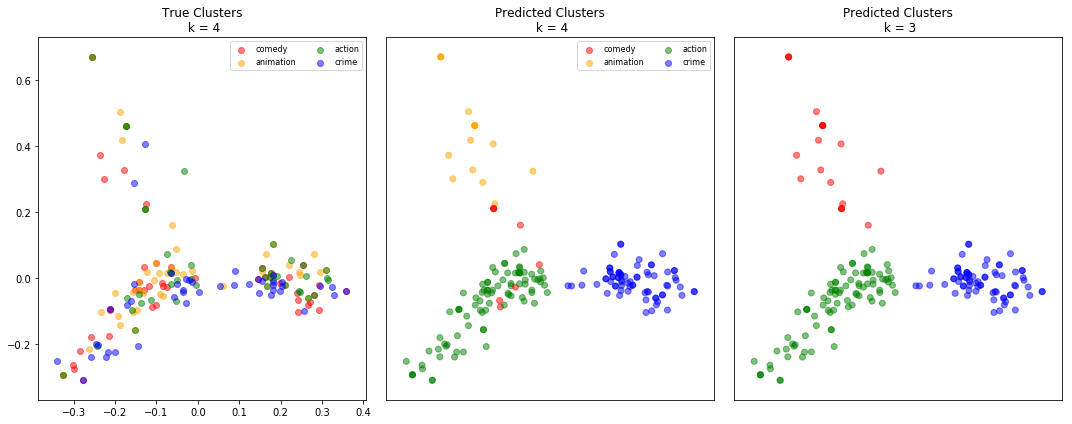

In [183]:
mycolor = ['red','orange','green','blue']
plt.figure(figsize = (15,6))

# True Cluster
plt.subplot(131)
comedy = plt.scatter(reduced_data[colors.index('red'):colors.index('blue')-1, 0], 
                   reduced_data[colors.index('red'):colors.index('blue')-1, 1], color=mycolor[0],alpha = 0.5)
animation = plt.scatter(reduced_data[colors.index('blue'):colors.index('green')-1, 0], 
                   reduced_data[colors.index('blue'):colors.index('green')-1, 1], color=mycolor[1],alpha = 0.5)
action = plt.scatter(reduced_data[colors.index('green'):colors.index('orange')-1, 0], 
                   reduced_data[colors.index('green'):colors.index('orange')-1, 1], color=mycolor[2],alpha = 0.5)
crime = plt.scatter(reduced_data[colors.index('orange'):, 0], 
                   reduced_data[colors.index('orange'):, 1], color=mycolor[3],alpha = 0.5)
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)
plt.title('True Clusters\n k = 4')

# Predicted Cluster 4 clusters
plt.subplot(132)
colors_p = [colordict[category[l]] for l in km.labels_]
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)
plt.title('Predicted Clusters\n k = 4')

# Predicted Cluster 3 clusters
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(MovieTFVects.toarray())
#Movie_Kingdom['Kmeans Prediction 3'] = km3.labels_

plt.subplot(133)
colors_p3 = [colordict[category[l]] for l in km3.labels_]
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p3, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')

plt.tight_layout()
plt.show()



<span style="color:purple"> **Flat Clustering Plot Analysis** <br>
**True Clusters** <br>
Dots with different colors mix with each other. This maybe due to two reasons. First, though a movie is categorized to one of four genres, it could have other genres as well. For instance, a animation could be a comeday simultanously. Hence when the authot is writing the movie critic, he may be very likely to mix genres, which leads to a mixed plot here. A second reason could be that critics itself is unable to be used to identify the movie's genre. <br>
However, a closer observation still tells some interesting things. The red dots (comedy) tend to be closer to the orange dots (animation). This is reasonable. In addition, even though blue dots tend to be everywhere, the biggest clustering of blue dots are at the middle on their own and with a little green dots (action). This reflects that crime is a relatively distinct gnere and some crime moveis could have action genre as well. <br>
**Predicted Clusters** <br>
The prediction has to be clear cut, which disobeys the analysis above about the *genre-mixture* phenomenon. Hence, the prediction is relatively poor. There is still an interesting finding -- If we see blue and green dots together, it will match the true cluster much better. This could reflect that crime and action are two close genres as mentioned above. <br>
Hence, I also test the data with 3 clusters. Two groups are now combined together into one. 
</span>


In [179]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

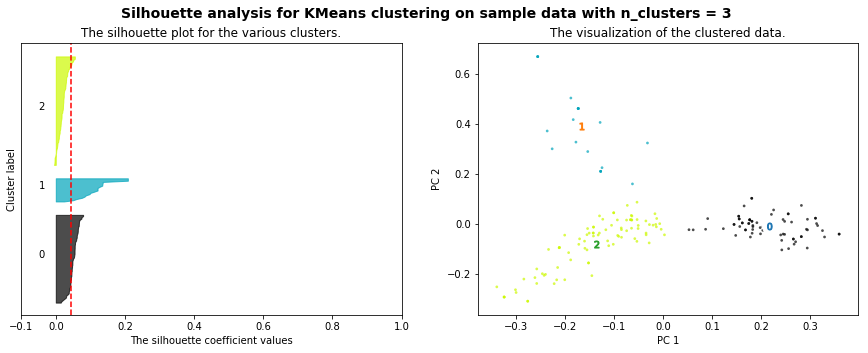

For n_clusters = 3, The average silhouette_score is : 0.043


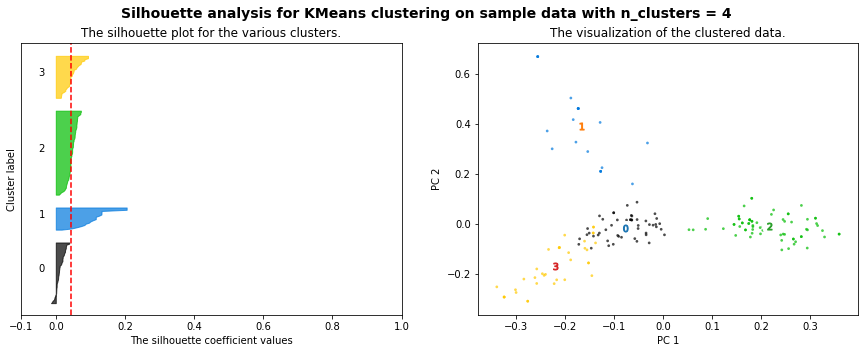

For n_clusters = 4, The average silhouette_score is : 0.044


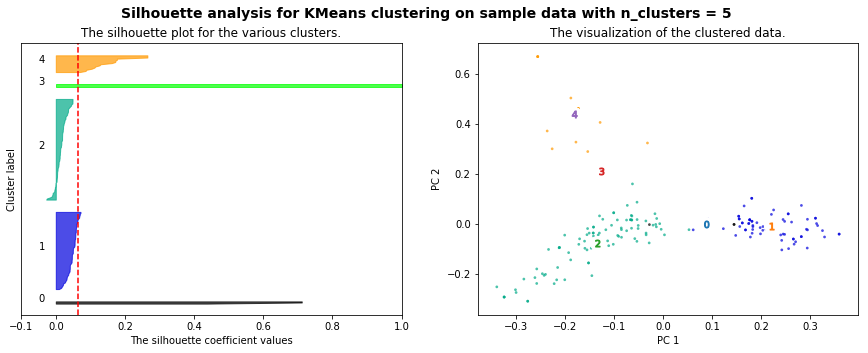

For n_clusters = 5, The average silhouette_score is : 0.066


In [190]:
# Silhouette -- Optimal Number of Clusters
X = MovieTFVects.toarray()
#plt.figure()
#plt.subplot(211)
plotSilhouette(3, X)
#plt.subplot(212)
plotSilhouette(4, X)
plotSilhouette(5, X)

#plt.tight_layout()
#plt.show()

### <span style="color:purple"> Add analysis of the Silhouette!!!! </span>

## <span style="color:purple"> SUMMARY </span>

# Hierarchical Clustering Analysis
## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

### <span style="color:purple"> Hierarchical Clustering Approach 1: .dendrogram( ) </span>

In [ ]:
MovieTFVects[:100].todense()

In [ ]:
MovieCoocMat = MovieTFVects * MovieTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
MovieCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate

In [ ]:
linkage_matrix = scipy.cluster.hierarchy.ward(MovieCoocMat.toarray())
linkage_matrix[:10]

In [ ]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

In [ ]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

### <span style="color:purple"> Hierarchical Clustering Approach 2: .fcluster( ) </span>

In [ ]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

In [ ]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(MovieCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(Movie_Kingdom['Movie Category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(Movie_Kingdom['Movie Category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(Movie_Kingdom['Movie Category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(Movie_Kingdom['Movie Category'], hierarchicalClusters_full)))

Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [ ]:
Movie_Kingdom['wald_predictions'] = hierarchicalClusters_full
Movie_Kingdom

As we only used one senator for this there isn't any point in looking at the metrics, but you should if possible

## <span style="color:purple"> SUMMARY </span>

# Topic Modeling
## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

To prepare a correctly formatted corpus for topic modeling and induction, I will do the following things:
Create the dictionary for corpus
Create the corpus
Serialize the corpus as a file and load it. (Important when the corpus is large)


Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [ ]:
# firstly, create a dictionary
Movie_Kingdom['Tokenized_Text'] = Movie_Kingdom['Movie_Critic'].apply(lambda x: nltk.word_tokenize(x))
Movie_Kingdom['Normalized_Tokens'] = Movie_Kingdom['Tokenized_Text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                 stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                 stemmer = lucem_illud.stemmer_basic))
Movie_Kingdom[::100]

In [ ]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]
Movie_Kingdom['Reduced_Tokens'] = Movie_Kingdom['Normalized_Tokens'].apply(lambda x: dropMissing(x, MovieTFVectorizer.vocabulary_.keys()))

In [ ]:
dictionary = gensim.corpora.Dictionary(Movie_Kingdom['Reduced_Tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [ ]:
# secondly, create a corpus
corpus = [dictionary.doc2bow(text) for text in Movie_Kingdom['Reduced_Tokens']]

----------to be deleted------------------
Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [ ]:
# thirdly, serialize the 
#-------------not sure about name of "Critic.mm"
gensim.corpora.MmCorpus.serialize('Critic.mm', corpus)
criticmm = gensim.corpora.MmCorpus('Critic.mm')

In [ ]:
Movielda = gensim.models.ldamodel.LdaModel(corpus=criticmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')


We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [ ]:
Movie1Bow = dictionary.doc2bow(Movie_Kingdom['Reduced_Tokens'][0])
Movie1lda = Movielda[Movie1Bow]

# ----------------not sure the senReleasesTraining['name']-----------
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(Movie1lda))

We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [ ]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [Movielda[dictionary.doc2bow(l)] for l in Movie_Kingdom['Reduced_Tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [ ]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(Movielda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [ ]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

In [ ]:
# First we can visualize as a stacked bar chart:
N = 10
ind = np.arange(N)
K = Movielda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')  # <----- to change

plt.title('Topics in Press Releases')  # <----- to change
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]  # <----- to change
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

In [ ]:
# We can also visualize as a heat map:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [ ]:
# We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. 
# To look at the terms with the highest LDA weight in topic `1` we can do the following:
Movielda.show_topic(1)    # <----- to change 1 ?????



In [ ]:
# And if we want to make a dataFrame:
topicsDict = {}
for topicNum in range(Movielda.num_topics):
    topicWords = [w for w, p in Movielda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

### <span style="color:purple"> Analysis Sample 
<span style="color:purple">We can see that several of the topics have the same top words, but there are definitely differences. </span>


<span style="color:red"> We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings. See how different $\eta$ values can change the shape of the distribution.

<span style="color:purple"> We can make a visualization of the distribution of words over any single topic.


In [ ]:
topic1_df = pandas.DataFrame(Movielda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [ ]:
# see the changes in eta
Movielda1 = gensim.models.ldamodel.LdaModel(corpus=criticmm, id2word=dictionary, num_topics=10, eta = 0.00001)
Movielda2 = gensim.models.ldamodel.LdaModel(corpus=criticmm, id2word=dictionary, num_topics=10, eta = 0.9)